# **Week 4: Lab Exercises for COMP499/691 Conversational AI**

The goal of this lab is to familiarize yourself with RNN-based Sequence-to-Sequence learning. This is a fundamental learning paradigm that we find in multiple tasks, such as machine translation and speech recognition. 

In the tutorial, we implemented RNN-based models from scratch. In this lab, we will implement it using SpeechBrain.


## **Task Description**







**Run the code below** to download the data.

In [ ]:
# Update gdown for the latest version
!pip install --upgrade --no-cache-dir gdown

!gdown 1UNaMsyhqzYYe5jOQH0p7QI99_WTil2rW

Once downloaded, we can follow it up by uncompress the data. **Run the code below** to unzip the downloaded file.

In [ ]:
%%capture
!unzip UDC.zip -d data

The dataset is split into training, validation, and test data as you can see by opening `train.csv`, `valid.csv`, and `test.csv`.

The data is formatted differently for the training data than it is for the validation and test data. 

The train data is separated into 3 columns: the context of the conversation (`Context`), the candidate response (`Utterance`), and a flag (`Label`) denoting whether the response is a 'true response' to the context (flag = 1), or a randomly drawn response from elsewhere in the dataset (flag = 0).

The validation and test data contain 11 columns. The row represents a question. Separated into 11 columns: the context (`Context`), the true response to the context (`Ground Truth Utterance`), and 9 false responses (`Distractors`) that were randomly sampled from elsewhere in the dataset. The model gets a question correct if it selects the ground truth utterance from amongst the 10 possible responses.

There are 1 000 000 sentences for training, 19 560 for validation, and 18 920 for testing.

In [ ]:
import pandas as pd
import spacy

TRAIN_FILE = './data/train.csv' 
VALID_FILE = './data/valid.csv'
TEST_FILE = './data/test.csv'

RAW_TRAIN_FILE = 'train.csv' 
RAW_VALID_FILE = 'valid.csv'
RAW_TEST_FILE = 'test.csv'

train = pd.read_csv(RAW_TRAIN_FILE)

# Only pick the positive ones
train = train[train.Label == 1]

In [ ]:
context = train['Context'].values

In [ ]:
import re

test = context[18]

nlp = spacy.blank("en")

nlp.tokenizer.add_special_case("__eot__", [{'ORTH': '__eot__'}])
nlp.tokenizer.add_special_case("__eou__", [{'ORTH': '__eou__'}])
nlp.tokenizer.add_special_case("__path__", [{'ORTH': '__path__'}])



In [ ]:
doc = nlp(context[5])
doc

In [ ]:
text = 'The script at /usr/local/bin/myscript.sh is not executable, as well as ~/Documents and ~/Desktop. Look me at http://google.com/search/index.asp  for work/tips on things'
regex = r"(^|\s)(~?(\/[A-Za-z.]+)+)+"
re.findall(regex, text)
re.sub(regex, ' __path__', text)

In [ ]:
import re

def preprocess(row):
    # case fold
    for key in ['context', 'response']:
        text = row[key]

        # Remove special characters
        text = re.sub('[^\w\s/.:@-]','', text)

        # Define regex pattern to match Bash paths and
        # replace the matches for __path__
        regex = r"(^|\s)(~?(\/[A-Za-z.]+)+)+/?"
        text = re.sub(regex, ' __path__', text)

        # case fold
        text = text.lower()
        
        # Run spacy
        doc = nlp(text)

        # Remove URLs
        tokens = []
        for token in doc:
            if token.is_space:
                continue
            elif token.like_url:
                tokens.append('__url__')
            elif token.like_email:
                tokens.append('__email__')
            elif token.like_num:
                tokens.append('__num__')
            else:
                tokens.append(token.text)
        row[key] = re.sub('[^a-z\s_]', '', ' '.join(tokens))
    return row
text = {
    'context': "yeah yeah, i fixed everything in ubuntu 12.04 12.04LTS /var/bin/ __eou__",
    'response': "12.04s DISPLAY:0 c++ http://www.linuxquestions.org/questions/linux-software-2/how-to-downgrade-to-older-skype-version-931400/"
};
preprocess(text)

In [ ]:
# 1. Only pick the ones that have the Label equal to 1
train = train[train.Label == 1]
# 2. Drop unneeded indices
train = train.reset_index().drop(['Label','index'], axis=1)
# 3. Rename columns
train = train.rename(columns={"Context": "context", "Utterance": "response"})

# 4. Set an ID column
train['ID'] = 'train_utt' + train.index.map(str)
train.set_index('ID', inplace=True)


In [ ]:
# add a step where train, valid and test sets are created the same (keep the labels = 1, save ground truth utterances)
import pandas as pd

TRAIN_FILE = './data/train.csv' 
VALID_FILE = './data/valid.csv'
TEST_FILE = './data/test.csv'

RAW_TRAIN_FILE = 'train.csv' 
RAW_VALID_FILE = 'valid.csv'
RAW_TEST_FILE = 'test.csv'

# Train script
train = pd.read_csv(RAW_TRAIN_FILE)
# 1. Only pick the ones that have the Label equal to 1
train = train[train.Label == 1]
# 2. Drop unneeded indices
train = train.reset_index().drop(['Label','index'], axis=1)
# 3. Rename columns
train = train.rename(columns={"Context": "context", "Utterance": "response"})

# 4. Set an ID column
train['ID'] = 'train_utt' + train.index.map(str)
train.set_index('ID', inplace=True)

# 5. Preprocess the text 
train = train.apply(preprocess, axis=1)

# 6. Save the file
train.to_csv(TRAIN_FILE, index_label='ID')

for input_file, output_file in [(RAW_VALID_FILE, VALID_FILE), (RAW_TEST_FILE, TEST_FILE)]:
  stage = input_file.split('.')[0]

  df = pd.read_csv(input_file)
  df = df.drop([
    'Distractor_0',
    'Distractor_1',
    'Distractor_2',
    'Distractor_3',
    'Distractor_4',
    'Distractor_5',
    'Distractor_6',
    'Distractor_7',
    'Distractor_8'
  ], axis=1)
  df = df.rename(columns={"Context": "context", "Ground Truth Utterance": "response"})
  df['ID'] = stage + '_utt' + df.index.map(str)
  df.set_index('ID', inplace=True)

  # Remove $ characters
  df = df.apply(preprocess, axis=1)

  df.to_csv(output_file, index_label='ID')

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

In [ ]:
vocab, embeddings = [],[]
with open('glove.6B.300d.txt','rt') as fi:
  for line in fi.readlines():
    i_word = line.split(' ')[0]
    i_embeddings = [float(val) for val in line.split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

In [ ]:
# convert
import numpy as np
import torch

# We will first convert the embeddings into a numpy array
# to facilitate the next following operations
embs_npa = np.array(embeddings)
vocab_npa = np.array(vocab)

# Then, we create four new rows to accomodate our special tokens
# <bos>,<eos>: to denote the beginning and ending of sentences
# <unk>: to handle out-of-vocabulary words
# <pad>: to pad the batched embeddings
#
# The sentence boundaries are handled with random tensors, while the
# unknown vector is a mean of all existing vectors in the vocabulary.
# As for the padding, it is a zero vector, and is not expected to be
# affected by the gradient in any way.
bos_emb_npa = np.random.randn(1, embs_npa.shape[1])
eos_emb_npa = np.random.randn(1, embs_npa.shape[1])
unk_emb_npa = np.mean(embs_npa, axis=0, keepdims=True)    #embedding for '<unk>' token.
pad_emb_npa = np.zeros((1, embs_npa.shape[1]))

# The special labels are added at the end of the vocabulary.
# Then we convert the array into pytorch and save it as a pt file for the parameter file
# to load later
embs_npa = np.vstack((embs_npa, bos_emb_npa, eos_emb_npa, unk_emb_npa, pad_emb_npa))
embs_pt = torch.from_numpy(embs_npa).float()
torch.save(embs_pt, 'embeddings_weights.pt')
np.save('embeddings_vocab.npy', vocab_npa)

In [ ]:
from speechbrain.dataio.encoder import TextEncoder

encoder = TextEncoder()
for i, t in enumerate(vocab):
  encoder.enforce_label(t, i)

encoder.add_bos_eos()
encoder.add_unk()
encoder.add_label('<pad>')


special_labels = encoder.encode_sequence(['<bos>','<eos>','<unk>','<pad>'])

print('Vocabulary size: %i' % len(encoder))
print('Special Labels IDs: \n<bos>: %i\n<eos>: %i\n<unk>: %i\n<pad>: %i\n' % tuple(special_labels))

## **Step 1: LSTM-based sequence-to-sequence learning**

Fortunately, you studied some sequence-to-sequence learning and you wanted to start with a simple RNN-based encoder-decoder architecture.

Your goal is to implement with [SpeechBrain](https://github.com/speechbrain/speechbrain/) the following architecture:




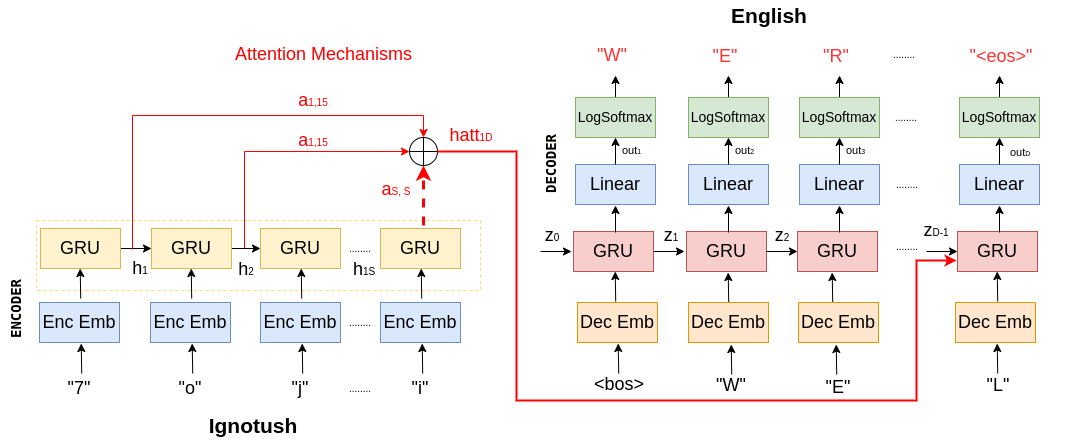

**Run the code below** to install speechbrain.

In [ ]:
%%capture
!pip install speechbrain

You wrote the following yaml file that declares all the components that we need.

**Run the code below** to save the hyperparameter file. Please, revise it carefully to start familiarizing yourself with this format.

In [ ]:
%%file LSTM_sentencepiece.yaml

# ############################################################################
# Model: E2E with attention-based Dialogue System
# Encoder: LSTM
# Decoder: LSTM
# Tokens: Piece of words
# losses: NLL
# Training: Context
##############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 1337
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Folder set up
data_folder: !PLACEHOLDER
output_folder: !ref results/LSTM_sentencepiece/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt
cer_file: !ref <output_folder>/test_cer.txt # file were to store the final character error rate on the test set.
tokenizer_file: /content/results/tokenizer/context/32000_bpe.model

# Path where data manifest files are stored
train_annotation: data/train_small.csv
valid_annotation: data/valid_small.csv
test_annotation: data/test_small.csv

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 5
batch_size: 128
lr: 0.001
lr_final: 0.0001

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>

# Vocabulary size
voc_size: 32000
emb_size: 128

# Indexes for begin-of-sentence (bos) 
# and end-of-sentence (eos)
unk_index: 0 # <unk>
bos_index: 1 # <bos>
eos_index: 2 # <eos>
pad_index: 3 # <pad>

# Encoder Parameters
enc_hidden_size: !ref <emb_size>
enc_num_layers: 2

# Decoder Parameters
dec_hidden_size: !ref <emb_size>
dec_num_layers: 1   
attn_dim: !ref <emb_size>
dropout: 0.5

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Encoder
encoder: !new:speechbrain.nnet.RNN.LSTM
    input_size: !ref <enc_hidden_size>
    hidden_size: !ref <enc_hidden_size>
    num_layers: !ref <enc_num_layers>
    dropout: !ref <dropout>

# Embeddings
embeddings: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <voc_size>
    embedding_dim: !ref <emb_size>
    
# Attention-based RNN decoder.
decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <enc_hidden_size>
    input_size: !ref <dec_hidden_size>
    rnn_type: lstm
    attn_type: content
    hidden_size: !ref <dec_hidden_size>
    attn_dim: !ref <attn_dim>
    num_layers: !ref <dec_num_layers>
    dropout: !ref <dropout>

# Linear transformation on the top of the decoder.
seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_hidden_size>
    n_neurons: !ref <voc_size>

# Final softmax (for log posteriors computation).
log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

tokenizer: !new:sentencepiece.SentencePieceProcessor

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>/tokenizers
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>

modules:
    encoder: !ref <encoder>
    embeddings: !ref <embeddings>
    decoder: !ref <decoder>
    seq_lin: !ref <seq_lin>




# This function manages learning rate annealing over the epochs.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
   
# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        counter: !ref <epoch_counter>


The RNN.yaml hyperparameter file is coupled with the following training script (train.py).

**Complete the code below** to implement the targeted system. You have to write your code in the `forward` and `compute_objective` methods where required. The code should match what is declared in the YAML file. Take this opportunity to further familiarize yourself with the SpeechBrain training script (they are all similar). In particular, try to understand the data flow: take a look at how we create and process entries declared in the CSV files, how we turn the sequence of chars into a sequence of corresponding integers,  how we turn the processed entries into batches, etc.

In [ ]:
%%file train_sentencepiece.py

#!/usr/bin/env/python3
"""Recipe for training a sequence-to-sequence machine translation system 
on "ignotush".
The system employs an encoder, a decoder, and an attention mechanism
between them. 

To run this recipe, do the following:
> python train.py train.yaml

With the default hyperparameters, the system employs an GRU encoder and decoder.

The neural network is trained with the negative-log likelihood objective and
characters are used as basic tokens for both english and ignotush.
"""

import os
import sys
import torch
import logging
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml

logger = logging.getLogger(__name__)



# Brain class for speech recognition training
class Dialogue(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computation of the CTC + seq2seq ASR. It returns the
        posterior probabilities of the CTC and seq2seq networks.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.tensor
            Log-probabilities predicted by the decoder.
            
        At validation/test time, it returns the predicted tokens as well.
        """
        
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device) # todo
        
        # Unpack the encoded context 
        enc_context, context_lens = batch.context_tokens
        
        # Context embeddings
        context_embeddings = self.modules.embeddings(enc_context)
        
        # Running the encoder
        encoded_signal, _ = self.modules.encoder(context_embeddings)
    
        # Unpacking the responses (with bos tokens)
        enc_response, response_lens = batch.response_encoded_tokens_bos
        
        # Response Embeddings
        response_embeddings = self.modules.embeddings(enc_response)

        # Running the decoder
        decoder_outputs, _ = self.modules.decoder(response_embeddings, encoded_signal, context_lens)
        
        # Compute logits (i.e., apply final linear transformation)
        # Your code here. Aim for 1 line
        logits = self.modules.seq_lin(decoder_outputs)
        
        # Compute log posteriors
        # Your code here. Aim for 1 line
        predictions = self.hparams.log_softmax(logits)
        
        if stage == sb.Stage.TEST:
            
            # Getting some predictions.
            hyps = predictions.argmax(-1)
            
            # getting the first index where the prediction is eos_index
            stop_indexes = (hyps == self.hparams.eos_index).int()
            stop_indexes = stop_indexes.argmax(dim=1)
            
            # Converting hyps from indexes to chars
            hyp_lst = []
            for hyp, stop_ind in zip(hyps, stop_indexes):
                # in some cases the eos is not observed (e.g, for the last sentence
                # in the batch)
                if stop_ind == 0:
                    stop_ind = -1
                # Stopping when eos is observed
                hyp = hyp[0:stop_ind]

                # From index to character
                hyp_lst.append(self.hparams.tokenizer.decode(hyp.tolist()))

            return predictions, hyp_lst
        
        return predictions
        

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.
        
        Arguments
        ---------
        predictions : torch.tTensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        # Unpack the response labels (with <eos>)
        enc_response_eos, english_lens = batch.response_encoded_tokens_eos
        
        # Reading the predictions
        if stage == sb.Stage.TEST:
          predictions, hyp_lst = predictions
          
          for inp, label, hyp in zip(batch.context, batch.response, hyp_lst):
              
              print("INP: " + inp)
              print("REF: " + label)
              print("HYP: " + hyp)
              print('--------')
        
        # Computing the nll_loss
        # Your code here. Aim for 1 line
        loss = sb.nnet.losses.nll_loss(predictions, enc_response_eos, english_lens)   
        
        return loss

            
    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch."""

        # Store the train loss until the validation stage.
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats


        # Perform end-of-iteration things, like annealing, logging, etc.
        elif stage == sb.Stage.VALID:
            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats={
                    "loss": stage_loss,
                },
            )
            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(
                meta={"loss": stage_stats["loss"]}, min_keys=["loss"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats={
                    "loss": stage_loss,
                },
            )
            

def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """


    tokenizer = hparams["tokenizer"]
    bos_index = hparams["bos_index"]
    eos_index = hparams["eos_index"]

    # Define text processing pipeline. We start from the raw text and then
    # split it into characters. The tokens with BOS are used for feeding
    # the decoder during training (right shifr), the tokens with EOS 
    # are used for computing the cost function.
    @sb.utils.data_pipeline.takes("context", "response")
    @sb.utils.data_pipeline.provides(
        "context",
        "context_tokens",
        "response",
        "response_encoded_tokens_bos",
        "response_encoded_tokens_eos",
        )
    def text_pipeline(context, response):
        """Processes the transcriptions to generate proper labels"""
        
        yield context
        # Use all of the words now
        ids = tokenizer.encode_as_ids(context)
        context_tokens = torch.LongTensor(ids)
        
        yield context_tokens

        yield response
        response_tokens = tokenizer.encode_as_ids(response)
        response_encoded_tokens_bos = torch.LongTensor([bos_index] + response_tokens)
        yield response_encoded_tokens_bos  
        response_encoded_tokens_eos = torch.LongTensor(response_tokens + [eos_index])
        yield response_encoded_tokens_eos                                              
      
        

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=data_info[dataset],
            dynamic_items=[text_pipeline],
            output_keys=[
                "context",
                "context_tokens",
                "response",
                "response_encoded_tokens_bos",
                "response_encoded_tokens_eos",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = True

        
    return datasets


if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    
    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )


    # We can now directly create the datasets for training, valid, and test
    datasets = dataio_prepare(hparams)

    # Trainer initialization
    translate_brain = Dialogue(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    translate_brain.fit(
        translate_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = translate_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


**Run the code below** to start training. We here use a CPU because the task is pretty fast. It might take 10-15 minutes to train the RNN model.

In [ ]:
!python train_sentencepiece.py LSTM_sentencepiece.yaml --device='cpu' --data_folder='.' --number_of_epochs=1 --batch_size=64

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model = GPT2LMHeadModel.from_pretrained('gpt2')
text = "hey guys got a question for you every time i connect to a new wifi network my __url__ gets reverted and the nameserver is defined as __num__ is there any way to make it stop doing this i m fairly sure resetting the dns servers to localhost should nt be default behaviour  __eou__ __eot__ master esta es la mejor forma  you need to set the immutable bit __eou__ sudo chattr i __path__ will make the file immutable that is no __num__ even root can change that file __eou__ __eot__ ca nt chattr i __eou__ __eot__ why not __eou__ __eot__ also tried on __path__ still no dice __eou__ __eot__ yeah i remember now about this give me a minute __eou__ __eot__ somewhere here says to add the acl option to automount points in fstab __eou__ __eot__"
ref = 'yup you are right __eou__ its ubuntu dude i see all kind of strange things happening here lol __eou__'
# encoded_input = tokenizer(text, return_tensors='pt')
tokenizer('<|response|>', return_tensors='pt')

# output = model(**expected_output, labels=expected_output['input_ids'])


In [ ]:
tokenizer.decode(output.logits.argmax(-1).tolist()[0])

In [ ]:
%%file hf_llm.py

import logging

from torch import Tensor
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel

logger = logging.getLogger(__name__)

class HuggingFaceLLM(nn.Module):
    """This lobe enables the integration of HuggingFace pretrained GPT model.
      Arguments
    ---------
    source : str
        HuggingFace hub name: e.g "gpt2"
    save_path : str
        Path (dir) of the downloaded model.
    freeze : bool (default: False)
        If True, the model is frozen. If False, the model will be trained
        alongside with the rest of the pipeline.
    """

    def __init__(self, source: str, save_path: str, freeze: bool = False) -> None:
        super().__init__()
        self.freeze = freeze
        self.model = AutoModelForCausalLM.from_pretrained(
            source,
            cache_dir=save_path
        )
        if self.freeze:
            logger.warning(
                "[HuggingFaceLLM] - LLM Model is frozen."
            )
            # We keep it to train() to have dropout and LN computed adequaly
            self.model.train()  
            for param in self.model.parameters():
                param.requires_grad = False


    def forward(self, input_ids: Tensor, token_type_ids: Tensor):
        with torch.set_grad_enabled(not self.freeze):
            output = self.model.forward(input_ids, token_type_ids=token_type_ids)
        return output


In [79]:
%%file GPT2.yaml

# ############################################################################
# Model: E2E with attention-based Dialogue System
# Encoder: GPT2
# Decoder: GPT2
# Tokens: GPT2
# losses: NLL
# Training: Context + Response
##############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 1337
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Folder set up
data_folder: !PLACEHOLDER
output_folder: !ref results/GPT2/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt
cer_file: !ref <output_folder>/test_gen.txt

# Pretrained Model Parameters
pretrained_model_name: gpt2
llm_folder: !ref <save_folder>/gpt_checkpoint

# Path where data manifest files are stored
train_annotation: data/train_small.csv
valid_annotation: data/valid_small.csv
test_annotation: data/test_small.csv

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


# Special Tokens
bos_token: "BOS"
eos_token: "EOS"

context_token: "CTX"
response_token: "REP"

additional_special_tokens : [
    !ref <context_token>,
    !ref <response_token>
]

special_tokens: [
    !ref <bos_token>,
    !ref <eos_token>,
    !ref <context_token>,
    !ref <response_token>
]

attr_to_special_tokens:
    "bos_token": !ref <bos_token>
    "eos_token": !ref <eos_token>
    "additional_special_tokens": !ref <additional_special_tokens>

# Training parameters
number_of_epochs: 5
batch_size: 4
test_batch_size: 1
lr: 1.97125e-4
with_eos: True

# Freeze GPT model 
freeze_llm: False

# Model parameters
llm_model: !new:hf_llm.HuggingFaceLLM
    source: !ref <pretrained_model_name>
    freeze: !ref <freeze_llm>
    save_path: !ref <llm_folder>

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <test_batch_size>

tokenizer: !new:transformers.AutoTokenizer.from_pretrained
    pretrained_model_name_or_path: !ref <pretrained_model_name>

modules:
    llm_model: !ref <llm_model>

model: !new:torch.nn.ModuleList
    - [!ref <llm_model>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

opt_class: !name:torch.optim.AdamW
    lr: !ref <lr>
   
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        counter: !ref <epoch_counter>


Overwriting GPT2.yaml


In [ ]:
%%file train_GPT2.py

#!/usr/bin/env/python3
"""Recipe for training an End-to-End dialogue system
The system employs a GPT-2 based Transformer Language Model. 

To run this recipe, do the following:
> python train_GPT2.py GPT2.yaml
"""

import os
import sys
import torch
import logging
import speechbrain as sb
from itertools import chain
from speechbrain.utils.distributed import run_on_main

from hyperpyyaml import load_hyperpyyaml

logger = logging.getLogger(__name__)

# Brain class for speech recognition training
class Dialogue(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Computation pipeline based on Transformer flow"""
        
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device) # tod
        
        
        # Get the inputs and token types
        input_ids, _ = batch.input_ids
        token_type_ids, _ = batch.token_type_ids

        # Running the model
        outputs = self.modules.llm_model(
            inputs,
            token_type_ids
        ).logits

        #  apply softmax if necessary
        outputs = self.hparams.log_softmax(outputs)

        return outputs
        

    def compute_objectives(self, loss, batch, stage):
        """Computes the loss given the predicted and targeted outputs.
        """
        
        # Get the labels
        lm_labels, labels_lens = batch.lm_labels

        # Calculate the loss
        loss = self.hparams.compute_cost(predictions, lm_labels, labels_lens)

        return loss

    def fit_batch(self, batch):
        """Trains the parameters given a single batch in input"""

        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)
        loss.backward()
        if self.check_gradients(loss):
            self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch."""

        # Store the train loss until the validation stage.
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats


        # Perform end-of-iteration things, like annealing, logging, etc.
        elif stage == sb.Stage.VALID:
            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats={
                    "loss": stage_loss,
                },
            )
            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(
                meta={"loss": stage_stats["loss"]}, min_keys=["loss"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        elif stage == sb.Stage.TEST:
            
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats={
                    "loss": stage_loss,
                },
            )
    
    def init_optimizers(self):
        "Initializes the model optimizer"
        self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

        if self.checkpointer is not None:
            self.checkpointer.add_recoverable("optimizer", self.optimizer)

    def zero_grad(self, set_to_none=False):
        self.optimizer.zero_grad(set_to_none)


def add_special_tokens_(
    model,
    tokenizer,
    attr_to_special_token,
) -> None:
    orig_num_tokens = len(tokenizer.encoder)
    num_added_tokens = tokenizer.add_special_tokens(
        attr_to_special_token  # type: ignore
    )  # doesn't add if they are already there
    if num_added_tokens > 0:
        model.resize_token_embeddings(new_num_tokens=orig_num_tokens + num_added_tokens)
 

def dataio_prepare(hparams, tokenizer):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # convert special tokens to their ids
    bos_token, eos_token, ctx_token, rep_token =  tokenizer.convert_tokens_to_ids(hparams["special_tokens"])

    # Define text processing pipeline. We start from the raw text and then
    # split it into characters. The tokens with BOS are used for feeding
    # the decoder during training (right shifr), the tokens with EOS 
    # are used for computing the cost function.
    @sb.utils.data_pipeline.takes("context", "response")
    @sb.utils.data_pipeline.provides(
        "input_ids",
        "token_type_ids",
        "lm_labels"
    )
    def input_and_token_type_pipeline(context, response):
        """Processes the transcriptions to generate proper labels"""

        # Encode the context and responses
        context_tokens = tokenizer.encode(context)
        response_tokens = tokenizer.encode(response)
        
        # Add the special tokens to the beginning of their sentences
        context_tokens = [ctx_token] + context_tokens
        response_tokens = [rep_token] + response_tokens

        # add the eos token if the parameter is on
        if hparams["with_eos"]:
            response_tokens = response_tokens + [eos_token]

        # concatenate the tokens to create the input sequence 
        input_ids = context_tokens + response_tokens
        input_ids = torch.LongTensor(input_ids)
        yield input_ids

        # Create the token type ids based on the lists above
        context_type_ids = [ctx_token]*len(context_tokens)
        reply_type_ids = [rep_token]*len(response_tokens)
        token_type_ids = context_type_ids + reply_type_ids
        token_type_ids = torch.LongTensor(token_type_ids)
        yield token_type_ids

        # Finally, create the ground truth label that will be used to
        # evaluate the reply generated by the LLM. -100 is a special
        # token that is ignored during the loss computation; the
        # idea is to mask everything except the reply produced.
        lm_labels = ([-100] * len(context_tokens)) + [-100] + response_tokens[1:]
        lm_labels = torch.LongTensor(lm_labels)
        yield lm_labels

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=data_info[dataset],
            dynamic_items=[input_and_token_type_pipeline],
            output_keys=[
                "utt_id",
                "input_ids",
                "token_type_ids",
                "lm_labels"
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = True

        
    return datasets


if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    
    # Initialize ddp (useful only for multi-GPU DDP training).
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Add special tokens to the tokenizer and resize model embedding
    add_special_tokens_(hparams['llm_model'], hparams['tokenizer'], hparams["attr_to_special_tokens"])

    # We can now directly create the datasets for training, valid, and test
    datasets = dataio_prepare(hparams, tokenizer)

    # Trainer initialization
    dialogue_brain = Dialogue(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    dialogue_brain.fit(
        dialogue_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = dialogue_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


In [8]:
import pandas as pd
train = pd.read_csv('./data/test_small.csv')

# Only pick the positive ones
context = train['context'].values


In [47]:
from speechbrain.dataio.batch import PaddedBatch

test = PaddedBatch([{'foo': 'bar'}])
ids, batch = test
ids

ValueError: not enough values to unpack (expected 2, got 1)

In [78]:
c = 'wtf  __eou__ mabu  do you have all the kernel patches __eou__ mabus __eou__ __eot__ kernel patches __eou__ __eot__ compiler errors __eou__ __eot__ __eou__ __eot__'


utts = []
for c in context[:50]:
    utts.append(list(filter(lambda x: x.strip() != '', ' '.join(c.split('__eot__')).split('__eou__'))))
#     # print(final)
#     print(len(final))
# #     print(c)
#     print('---')
max_hist = 1
utts[0][-(max_hist):]

['   thanks how the heck did you figure that out ']